# Lab 8-1. CNN model의 활용 (1)

### 이번 실습은 Classification 이외에도 CNN 모델을 활용하는 법을 배워보겠습니다.

### 먼저 Penn-Fudan 데이터셋을 활용하여 torchvision 에 있는 Object Detection 모델을 사용하는 법을 배워보겠습니다. 







### Drive mount and package import

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models




In [3]:
# data 경로 설정 
# root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
root = os.path.join(os.getcwd(), "drive", "MyDrive", "프로그래밍_교육", "쏘카 ai 엔지니어 육성 부트캠프 2기", "강의", "data")

### PennFudanPed 데이터셋
보행자 Detection 과 Segmentation 을 위한 데이터셋입니다.
170 개의 이미지와 345 명의 labeled 된 보행자의 데이터가 있습니다. 
데이터는 Universitiy of Pennsylvania, Fudan University 에서 수집했다고 합니다.

### PennFudanPed 데이터셋 확인하기

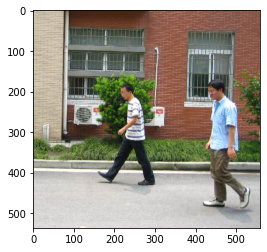

In [4]:
image = Image.open(os.path.join(root,'PennFudanPed/PNGImages/FudanPed00001.png'))
plt.imshow(image)

1

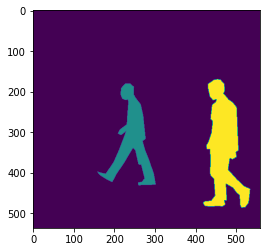

In [5]:
mask = Image.open(os.path.join(root,'PennFudanPed/PedMasks/FudanPed00001_mask.png'))
plt.imshow(mask)

np.array(mask)[400,200]
# np.array(mask)[400,450]

### Dataset class

In [6]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, mode='detection'):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
        self.mode = mode
        
        # 다룰 task 에 따라서 dataset 을 불러 오는 mode를 다르게 함
        if not (self.mode == 'detection' or self.mode == 'segmentation'):
            raise ValueError(f"mode {self.mode} is not supproted")
        
    def __getitem__(self, idx):
        # 이미지와 마스크 불러오기
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        
        # Object Detection mode
        if self.mode == 'detection':
            obj_ids = np.unique(mask)            # mask 의 object id 들의 list 를 만듦
            obj_ids = obj_ids[1:]                # 0 은 background 라 빼줌

            masks = mask == obj_ids[:, None, None]    # 각 object id 별로 mask를 따로 만들어줌

            num_objs = len(obj_ids)

            # object 별 mask 의 가장자리 위치를 기준으로 bounding box 를 만듦
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target
        
        # Semantic segmentation mode
        elif self.mode == 'segmentation':
            mask[mask > 0] = 1                # object 가 있는 부분은 전부 1로 mask 수정 -> 다 같은 pedestrian class

            mask = torch.as_tensor(mask, dtype=torch.uint8)

            target = {}
            target["mask"] = mask

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target

    def __len__(self):
        return len(self.imgs)

### Data transforms

In [7]:
class ToTensor(object):
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        return image, target

class Normalize(object):
    def __call__(self, image, target):
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


In [8]:
infer_transform = Compose([
    ToTensor(),
])

In [9]:
dataset_detection = PennFudanDataset(os.path.join(root,'PennFudanPed/'), transforms=infer_transform, mode='detection')
dataset_detection[0]

(tensor([[[0.8275, 0.8235, 0.8314,  ..., 0.5608, 0.5725, 0.5804],
          [0.7020, 0.6784, 0.6667,  ..., 0.4941, 0.5020, 0.5020],
          [0.8000, 0.7608, 0.7373,  ..., 0.5098, 0.5137, 0.5098],
          ...,
          [0.8863, 0.8510, 0.8275,  ..., 0.7176, 0.7216, 0.7255],
          [0.9059, 0.8588, 0.8235,  ..., 0.7333, 0.7333, 0.7294],
          [0.8824, 0.8902, 0.8431,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7843, 0.7804, 0.7882,  ..., 0.3765, 0.3882, 0.3961],
          [0.6588, 0.6353, 0.6235,  ..., 0.3098, 0.3176, 0.3176],
          [0.7569, 0.7176, 0.6941,  ..., 0.3255, 0.3294, 0.3255],
          ...,
          [0.8627, 0.8275, 0.8039,  ..., 0.7176, 0.7216, 0.7255],
          [0.8824, 0.8353, 0.8000,  ..., 0.7333, 0.7333, 0.7294],
          [0.8588, 0.8667, 0.8196,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7137, 0.7098, 0.7176,  ..., 0.3059, 0.3176, 0.3255],
          [0.5882, 0.5647, 0.5529,  ..., 0.2392, 0.2471, 0.2471],
          [0.6863, 0.6471, 0.6235,  ...,

### Model import

In [10]:
det_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

### Inference Model

In [11]:
data_loader = DataLoader(dataset_detection, batch_size=1, shuffle=True)


images,targets = next(iter(data_loader))
images = list(image for image in images)
# For inference
det_model.eval()
predictions = det_model(images)  

In [12]:
targets

{'boxes': tensor([[[138.,  36., 252., 338.],
          [  2.,  36.,  94., 341.],
          [315.,  42., 447., 338.]]]), 'labels': tensor([[1, 1, 1]])}

In [13]:
predictions

[{'boxes': tensor([[9.4694e-01, 3.6433e+01, 9.5052e+01, 3.3519e+02],
          [3.3085e+02, 3.9926e+01, 4.5009e+02, 3.3992e+02],
          [1.4201e+02, 3.3080e+01, 2.5335e+02, 3.3772e+02],
          [3.3016e+02, 8.4181e+01, 3.6778e+02, 1.7714e+02],
          [2.0122e+02, 0.0000e+00, 2.5048e+02, 1.0263e+02],
          [1.4130e+02, 2.0238e+02, 1.5859e+02, 2.2429e+02],
          [6.9667e+01, 1.3272e+02, 9.6124e+01, 1.7232e+02],
          [3.1739e+02, 8.2466e+01, 3.6810e+02, 2.2257e+02],
          [1.6382e-01, 4.9044e+01, 1.6440e+01, 9.9560e+01],
          [3.1530e+02, 1.6496e+02, 3.5671e+02, 2.2611e+02],
          [2.4428e+02, 0.0000e+00, 2.9207e+02, 1.2499e+02],
          [0.0000e+00, 6.9446e+01, 2.2652e+01, 2.0857e+02],
          [2.3446e+02, 1.1391e+02, 3.1329e+02, 2.3959e+02],
          [6.6408e+01, 1.2307e+02, 8.6119e+01, 1.7586e+02],
          [4.4918e+02, 6.7834e+01, 4.6122e+02, 9.7370e+01],
          [4.4038e+02, 2.0325e+01, 4.6644e+02, 1.3330e+02],
          [2.3447e+02, 1.1634e+

### Object Class

In [14]:
COCO_labels = np.array(open(os.path.join(root,"COCO_labels.txt")).read().splitlines())
COCO_labels

array(['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
       'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
       'street sign', 'stop sign', 'parking meter', 'bench', 'bird',
       'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
       'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses',
       'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
       'sports ball', 'kite', 'baseball bat', 'baseball glove',
       'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate',
       'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
       'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
       'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
       'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv',
       'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
       'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book

In [15]:
COCO_labels[predictions[0]['labels']]

array(['person', 'person', 'person', 'handbag', 'person',
       'baseball glove', 'handbag', 'handbag', 'person', 'handbag',
       'person', 'person', 'truck', 'handbag', 'handbag', 'person',
       'refrigerator', 'backpack', 'person', 'backpack', 'handbag',
       'suitcase', 'tv', 'backpack', 'person', 'handbag', 'backpack',
       'handbag', 'person', 'person', 'backpack', 'person', 'person',
       'person', 'tie'], dtype='<U14')

### Visualization

In [16]:
from PIL import ImageDraw

def draw_bounding_boxes(image, boxes, labels, pred=False, confs=None, confidence_th=None):

    if pred:
      valid = np.where(confs>confidence_th)
      boxes = boxes[valid]
      labels = labels[valid]

    img_to_draw = Image.fromarray(image)
    draw = ImageDraw.Draw(img_to_draw)

    for i, bbox in enumerate(boxes):
        draw.rectangle(bbox)
        draw.text((bbox[0]+2,bbox[1]+2), str(labels[i]))

    return img_to_draw

In [17]:
image = (images[0].permute(1,2,0).numpy()*255).astype(np.uint8)

gt_boxes = targets['boxes'].detach().numpy()[0]
gt_labels = COCO_labels[targets['labels']][0]
gt_bbox_img = draw_bounding_boxes(image, gt_boxes, gt_labels)

In [18]:
prediction = predictions[0]
boxes = prediction['boxes'].detach().numpy()
labels = COCO_labels[predictions[0]['labels']]
conf = prediction['scores'].detach().numpy()


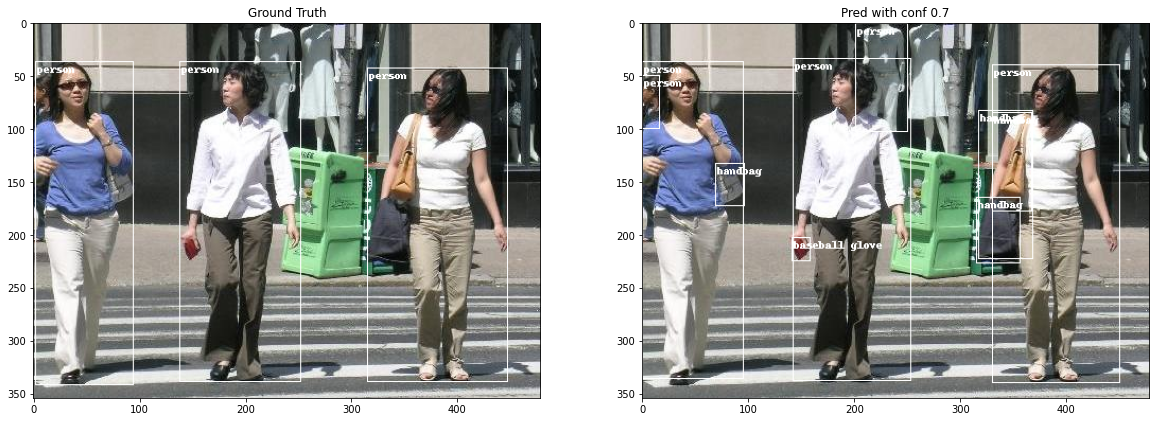

In [19]:
conf_th = 0.7
bbox_img = draw_bounding_boxes(image, boxes, labels, pred=True, confs=conf, confidence_th=conf_th)



fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(gt_bbox_img)
ax.title.set_text("Ground Truth")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(bbox_img)
ax.title.set_text(f"Pred with conf {conf_th}")
fig.show()